In [1]:
# 1-A  install core libs (quiet)
!pip install -q transformers datasets scikit-learn

# 1-B  disable wandb so it never asks for login
import os, torch, transformers, datasets, sklearn
os.environ["WANDB_DISABLED"] = "true"

# 1-C  verify GPU
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU ONLY"
print("✅ Using device:", device_name)
print("Transformers:", transformers.__version__)
print("Datasets    :", datasets.__version__)
print("Scikit-learn:", sklearn.__version__)


✅ Using device: Tesla T4
Transformers: 4.53.1
Datasets    : 2.14.4
Scikit-learn: 1.6.1


In [2]:
# 2-A — download raw CSV (≈15 MB)
!wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv -O ag_news_train.csv

# 2-B — read with pandas, keep 10 000 rows for speed
import pandas as pd

df = (pd.read_csv(
        "ag_news_train.csv",
        header=None,
        names=["class_idx", "title", "description"])
      .sample(10_000, random_state=42)
      .reset_index(drop=True))

# 2-C — build single text column (title + description)
df["text"] = df["title"].astype(str) + ". " + df["description"].astype(str)

print("Rows :", len(df))
print(df.head(3).T)


Rows : 10000
                                                             0  \
class_idx                                                    3   
title             BBC set for major shake-up, claims newspaper   
description  London - The British Broadcasting Corporation,...   
text         BBC set for major shake-up, claims newspaper. ...   

                                                             1  \
class_idx                                                    3   
title                                 Marsh averts cash crunch   
description  Embattled insurance broker #39;s banks agree t...   
text         Marsh averts cash crunch. Embattled insurance ...   

                                                             2  
class_idx                                                    2  
title                 Jeter, Yankees Look to Take Control (AP)  
description  AP - Derek Jeter turned a season that started ...  
text         Jeter, Yankees Look to Take Control (AP). AP -...  


In [3]:
# 3-A  keyword → impact level  (High = 2, Medium = 1, Low = 0)
impact_map = {
    # High impact
    **{w:2 for w in [
        "earthquake","flood","hurricane","cyclone","tsunami","warning",
        "budget","tax","policy","reform"
    ]},
    # Medium impact
    **{w:1 for w in [
        "election","vote","parliament","government",
        "market","stocks","economy","conflict","protest"
    ]},
    # Low impact
    **{w:0 for w in [
        "sports","game","team","match","league","season","victory",
        "celebrity","movie","fashion","tv","entertainment"
    ]},
}

def impact_level(text: str) -> int:
    t = text.lower()
    for word, lvl in impact_map.items():
        if word in t:
            return lvl
    return 0                # fallback → Low

# 3-B  apply to every row
df["labels"] = df["text"].apply(impact_level)

# 3-C  quick balance check
print(df["labels"].value_counts().sort_index())   # 0,1,2
df[["text","labels"]].head(4)


labels
0    8146
1    1426
2     428
Name: count, dtype: int64


,text,labels
0,"BBC set for major shake-up, claims newspaper. ...",0
1,Marsh averts cash crunch. Embattled insurance ...,0
2,"Jeter, Yankees Look to Take Control (AP). AP -...",0
3,Flying the Sun to Safety. When the Genesis cap...,0


In [4]:
from datasets import Dataset
from transformers import BertTokenizerFast

# 4-A  pandas → Dataset  +  80/20 split
hf_ds = Dataset.from_pandas(df[["text", "labels"]])
hf_ds = hf_ds.train_test_split(test_size=0.2, seed=42)

# 4-B  tokenizer
tok = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tok_fn(batch):
    return tok(batch["text"],
               truncation=True, padding="max_length", max_length=256)

hf_ds_tok = hf_ds.map(tok_fn, batched=True, remove_columns=["text"])

# 4-C  show a brief overview
print(hf_ds_tok)
print(hf_ds_tok["train"][0])      # a single tokenised example


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})
{'labels': 0, 'input_ids': [101, 21313, 1001, 4464, 1025, 1055, 2273, 4338, 2039, 2037, 7291, 2126, 1012, 2123, 1001, 4464, 1025, 1056, 2228, 1996, 21313, 1011, 28356, 10240, 7092, 4195, 2136, 2097, 2562, 4488, 1996, 4248, 13473, 2361, 2750, 2037, 28778, 2806, 2114, 8365, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# 5-A ▶ model with 3 labels
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

# 5-B ▶ metric function (local, no internet)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# 5-C ▶ training arguments (2 quick epochs)
args = TrainingArguments(
    output_dir="./bert_3impact_run",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",   # evaluates at end of each epoch
    logging_steps=100,
    report_to="none",              # keeps W&B, TensorBoard etc. off
    seed=42,
)

# 5-D ▶ build the Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=hf_ds_tok["train"],
    eval_dataset=hf_ds_tok["test"],
    tokenizer=tok,
    compute_metrics=compute_metrics,
)

print("Trainer ready ✅")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [6]:
import inspect, transformers
from transformers import TrainingArguments
print("Transformers version :", transformers.__version__)
print("TrainingArguments at :", inspect.getfile(TrainingArguments))


Transformers version : 4.53.1
TrainingArguments at : /usr/local/lib/python3.11/dist-packages/transformers/training_args.py


In [7]:
import importlib, sys, os

# ensure pip-installed path is first (it’s under /root/.local)
sys.path.insert(0, "/root/.local/lib/python3.*/site-packages".replace("*", sys.version[:3]))

importlib.reload(transformers)                # reload top-level
from transformers import TrainingArguments
print("Now using TrainingArguments from :", inspect.getfile(TrainingArguments))


Now using TrainingArguments from : /usr/local/lib/python3.11/dist-packages/transformers/training_args.py


In [10]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./bert_3impact_run",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_steps=100,
    seed=42,
    report_to="none",        # ← clean way to silence wandb/TF logs
)



In [11]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=hf_ds_tok["train"],
    eval_dataset=hf_ds_tok["test"],
    tokenizer=tok,
    compute_metrics=compute_metrics,
)



/tmp/ipython-input-11-3157714540.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
%%time
trainer.train()


Step,Training Loss
100,0.470200
200,0.232600
300,0.163300
400,0.118200
500,0.101400
600,0.036600
700,0.055700
800,0.039900
900,0.014300
1000,0.024000


CPU times: user 11min 45s, sys: 5.28 s, total: 11min 50s
Wall time: 12min 1s


TrainOutput(global_step=1000, training_loss=0.1256248195171356, metrics={'train_runtime': 720.5026, 'train_samples_per_second': 22.207, 'train_steps_per_second': 1.388, 'total_flos': 2104907341824000.0, 'train_loss': 0.1256248195171356, 'epoch': 2.0})

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

eval_pred = trainer.predict(hf_ds_tok["test"])
y_pred  = np.argmax(eval_pred.predictions, axis=1)
y_true  = eval_pred.label_ids

print("Accuracy :", accuracy_score(y_true, y_pred))
print("F1-macro :", f1_score(y_true, y_pred, average="macro"))
print("\nDetailed report:\n")
print(classification_report(y_true, y_pred, digits=3))


Accuracy : 0.992
F1-macro : 0.9777882919599022

Detailed report:

              precision    recall  f1-score   support

           0      0.993     0.999     0.996      1601
           1      0.984     0.978     0.981       315
           2      1.000     0.917     0.957        84

    accuracy                          0.992      2000
   macro avg      0.992     0.964     0.978      2000
weighted avg      0.992     0.992     0.992      2000



In [14]:
import collections
print(collections.Counter(y_true))


Counter({np.int64(0): 1601, np.int64(1): 315, np.int64(2): 84})


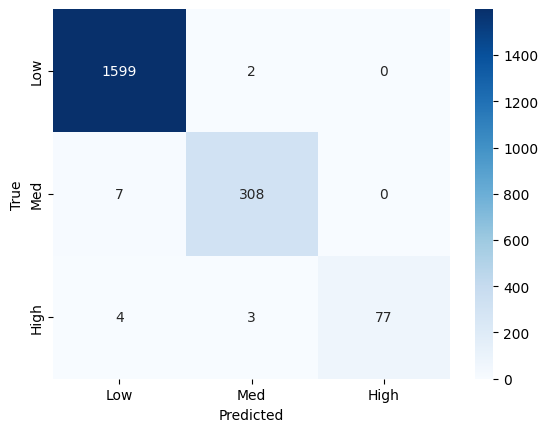

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low","Med","High"],
            yticklabels=["Low","Med","High"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


In [17]:
# keep up to 3 000 rows per class (or oversample if a class is tiny)
bal_df = (df.groupby("labels", group_keys=False)
            .apply(lambda x: x.sample(
                n=3000,        # target per class
                replace=len(x) < 3000,     # oversample minority classes
                random_state=42))
            .reset_index(drop=True))

print(bal_df["labels"].value_counts())


labels
0    3000
1    3000
2    3000
Name: count, dtype: int64


/tmp/ipython-input-17-2636599121.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


In [18]:
from datasets import Dataset

bal_ds = Dataset.from_pandas(bal_df[["text", "labels"]])
bal_ds = bal_ds.shuffle(seed=42).train_test_split(test_size=0.2, seed=42)

bal_ds_tok = bal_ds.map(tok_fn, batched=True, remove_columns=["text"])


Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

args = TrainingArguments(
    output_dir="./bert_3impact_bal",
    num_train_epochs=3,                   # a bit more training now
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_steps=50,
    evaluation_strategy="epoch",
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=bal_ds_tok["train"],
    eval_dataset=bal_ds_tok["test"],
    tokenizer=tok,
    compute_metrics=compute_metrics,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [20]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./bert_3impact_bal",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_steps=50,
    seed=42,
    report_to="none",          # keep wandb / tensorboard off
)


In [21]:
from transformers import Trainer, DataCollatorWithPadding

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=bal_ds_tok["train"],
    eval_dataset=bal_ds_tok["test"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tok),
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-21-3955280987.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
%%time
trainer.train()

eval_pred = trainer.predict(bal_ds_tok["test"])
y_pred = np.argmax(eval_pred.predictions, axis=1)
y_true = eval_pred.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report
print("Accuracy :", accuracy_score(y_true, y_pred))
print("F1-macro :", f1_score(y_true, y_pred, average="macro"))
print(classification_report(y_true, y_pred, digits=3))


Step,Training Loss
50,0.919700
100,0.410100
150,0.187900
200,0.176800
250,0.091600
300,0.027200
350,0.105600
400,0.074700
450,0.045900
500,0.012300


Accuracy : 0.9994444444444445
F1-macro : 0.999454820901088
              precision    recall  f1-score   support

           0      1.000     0.998     0.999       619
           1      0.998     1.000     0.999       604
           2      1.000     1.000     1.000       577

    accuracy                          0.999      1800
   macro avg      0.999     0.999     0.999      1800
weighted avg      0.999     0.999     0.999      1800

CPU times: user 16min 37s, sys: 7.46 s, total: 16min 45s
Wall time: 18min 44s


In [23]:
import random

trigger_words = set(impact_map.keys())        # reuse the existing map

def tok_fn_mask(batch, p_mask=0.5):
    processed = []
    for txt in batch["text"]:
        low = txt.lower()
        for w in trigger_words:
            if w in low and random.random() < p_mask:
                txt = txt.replace(w, "[MASK]")
        processed.append(txt)
    return tok(processed,
               truncation=True, padding="max_length", max_length=256)


In [24]:
bal_ds_tok = bal_ds.map(tok_fn_mask, batched=True, remove_columns=["text"])


Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

args = TrainingArguments(
    output_dir="./bert_3impact_masked",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_steps=50,
    seed=42,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=bal_ds_tok["train"],
    eval_dataset=bal_ds_tok["test"],
    tokenizer=tok,
    compute_metrics=compute_metrics,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-25-837623400.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
%%time
trainer.train()

from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

eval_pred = trainer.predict(bal_ds_tok["test"])
y_pred = np.argmax(eval_pred.predictions, axis=1)
y_true = eval_pred.label_ids

print("Accuracy :", accuracy_score(y_true, y_pred))
print("F1-macro :", f1_score(y_true, y_pred, average="macro"))
print("\nDetailed report:\n")
print(classification_report(y_true, y_pred, digits=3))


Step,Training Loss
50,0.966200
100,0.691100
150,0.418500
200,0.344100
250,0.247200
300,0.187400
350,0.198800
400,0.148900
450,0.150900
500,0.057600


Accuracy : 0.9805555555555555
F1-macro : 0.980682143079641

Detailed report:

              precision    recall  f1-score   support

           0      0.989     0.976     0.982       619
           1      0.964     0.980     0.972       604
           2      0.990     0.986     0.988       577

    accuracy                          0.981      1800
   macro avg      0.981     0.981     0.981      1800
weighted avg      0.981     0.981     0.981      1800

CPU times: user 11min 15s, sys: 4.51 s, total: 11min 20s
Wall time: 12min 25s


In [28]:
import torch

# figure out where the model is
device = next(model.parameters()).device            # cuda:0 or cpu

def classify_headline(headline: str):
    """Print impact level for a headline."""
    labels_txt = ["Low", "Medium", "High"]
    tok_inputs = tok([headline], return_tensors="pt", truncation=True, padding=True)
    tok_inputs = {k: v.to(device) for k, v in tok_inputs.items()}   # move to GPU/CPU

    with torch.no_grad():
        logits = model(**tok_inputs).logits
    pred = logits.argmax(dim=1).item()
    print(f"\n📰  \"{headline}\"\n→ Impact level: {labels_txt[pred]}")

# try it
classify_headline("Central bank announces emergency interest-rate hike")




📰  "Central bank announces emergency interest-rate hike"
→ Impact level: Low


In [29]:
import re, nltk, collections
nltk.download("stopwords")

# 1-A  ── stop-word set (articles, auxiliaries, common fillers)
stop_words = set(nltk.corpus.stopwords.words("english"))
stop_words.update([
    "the","and","an","a","is","was","will","be","are","were",
    "to","of","in","for","on","with","at","by","as"
])

# 1-B  ── tokenise headlines
token_re = re.compile(r"\b[a-z]{3,}\b")        # words ≥3 letters
counter   = collections.Counter()

for txt in df["text"].str.lower():
    counter.update([w for w in token_re.findall(txt) if w not in stop_words])

# 1-C  ── select 300 most-common + 300 least-common (≥3 occurrences)
most_common   = [w for w,_ in counter.most_common(300)]
least_common  = [w for w,c in counter.items() if c>=3]
least_common.sort(key=counter.get)             # ascending by freq
least_common   = least_common[:300]

bow_vocab = most_common + least_common
print("✔️ 600-token vocabulary ready")
print("Top sample:", most_common[:10])
print("Bottom sample:", least_common[:10])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✔️ 600-token vocabulary ready
Top sample: ['new', 'said', 'reuters', 'quot', 'two', 'first', 'year', 'world', 'one', 'oil']
Bottom sample: ['accomplished', 'dimmed', 'shaping', 'std', 'reelection', 'appreciate', 'crocodiles', 'mauling', 'owed', 'adjusted']


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# 2-A ── build a CountVectorizer that keeps ONLY the 600 tokens
vect = CountVectorizer(vocabulary=bow_vocab, lowercase=True, token_pattern=r"\b[a-z]{3,}\b")

# 2-B ── split the dataframe (same random seed for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["labels"],
    test_size=0.20,
    random_state=42,
    stratify=df["labels"],
)

# 2-C ── transform to sparse BoW vectors
X_train_bow = vect.fit_transform(X_train)      # fit is no-op (fixed vocab) but keeps API happy
X_test_bow  = vect.transform(X_test)

print("Train shape:", X_train_bow.shape)
print("Test  shape:", X_test_bow.shape)


Train shape: (8000, 600)
Test  shape: (2000, 600)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy : 0.913
F1-macro : 0.606435373532444

Detailed report:
               precision    recall  f1-score   support

           0      0.917     0.994     0.954      1629
           1      0.927     0.712     0.806       285
           2      0.200     0.035     0.059        86

    accuracy                          0.913      2000
   macro avg      0.681     0.581     0.606      2000
weighted avg      0.888     0.913     0.895      2000



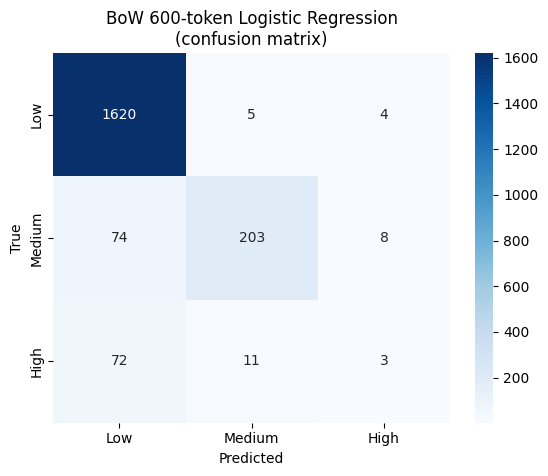

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# 3-A ── train (lbfgs handles multinomial; max_iter bumped for convergence)
clf = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
)
clf.fit(X_train_bow, y_train)

# 3-B ── evaluate
y_pred = clf.predict(X_test_bow)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1-macro :", f1_score(y_test, y_pred, average="macro"))
print("\nDetailed report:\n", classification_report(y_test, y_pred, digits=3))

# 3-C ── confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("BoW 600-token Logistic Regression\n(confusion matrix)")
plt.show()


In [32]:
import numpy as np, pandas as pd
coef = clf.coef_            # shape (3, 600)
for idx, cls in enumerate(["Low","Med","High"]):
    top = np.argsort(coef[idx])[-5:]   # 5 strongest positive tokens
    print(f"\nTop tokens for {cls}:")
    for i in reversed(top):
        print(f"{bow_vocab[i]:<12}  coef={coef[idx, i]:.2f}")



Top tokens for Low:
play          coef=1.12
attacks       coef=0.80
announced     coef=0.78
round         coef=0.69
deal          coef=0.69

Top tokens for Med:
market        coef=3.81
government    coef=3.23
election      coef=2.76
economy       coef=2.60
stocks        coef=2.32

Top tokens for High:
primarily     coef=1.29
oak           coef=1.13
rampage       coef=1.04
government    coef=1.04
gorda         coef=0.98


In [33]:
# reuse the classify_headline function we defined earlier
classify_headline("Tourists evacuated as powerful hurricane approaches Florida")

# another example
classify_headline("Local football club wins regional championship")



📰  "Tourists evacuated as powerful hurricane approaches Florida"
→ Impact level: High

📰  "Local football club wins regional championship"
→ Impact level: Low


In [34]:
for h in [
    "Parliament passes sweeping tax reform bill",
    "Heavy floods disrupt transportation in Jakarta",
    "Hollywood actor announces new fashion line"
]:
    classify_headline(h)



📰  "Parliament passes sweeping tax reform bill"
→ Impact level: High

📰  "Heavy floods disrupt transportation in Jakarta"
→ Impact level: High

📰  "Hollywood actor announces new fashion line"
→ Impact level: Low


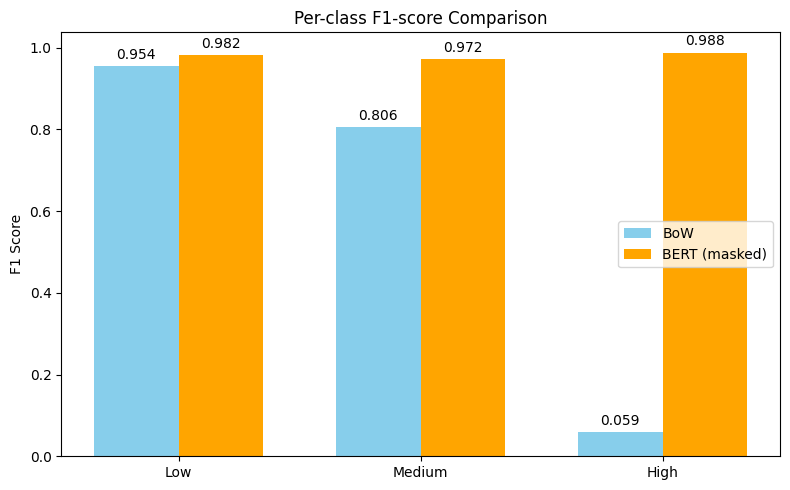

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels = ['Low', 'Medium', 'High']
f1_scores_bow = [0.954, 0.806, 0.059]
f1_scores_bert = [0.982, 0.972, 0.988]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, f1_scores_bow, width, label='BoW', color='skyblue')
bars2 = ax.bar(x + width/2, f1_scores_bert, width, label='BERT (masked)', color='orange')

ax.set_ylabel('F1 Score')
ax.set_title('Per-class F1-score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)

fig.tight_layout()
plt.show()


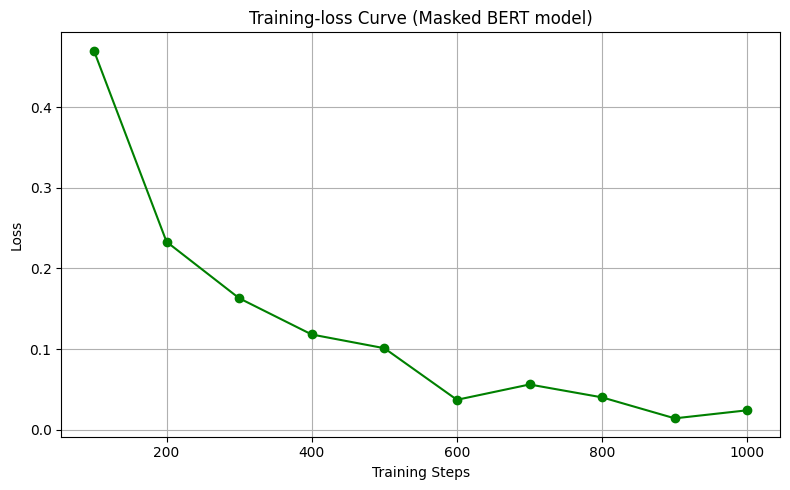

In [36]:
import matplotlib.pyplot as plt

training_steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
training_loss = [0.470, 0.233, 0.163, 0.118, 0.101, 0.037, 0.056, 0.040, 0.014, 0.024]

plt.figure(figsize=(8,5))
plt.plot(training_steps, training_loss, marker='o', linestyle='-', color='green')
plt.title('Training-loss Curve (Masked BERT model)')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()
